In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = '339'
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
load_directory = os.path.join(dataset_path,F'fly_{fly}/func_0')

In [3]:
brain = {}
for j,ch in enumerate(['red', 'green']):
    print(ch)
    file = os.path.join(load_directory, F'functional_channel_{j+1}_moco_zscore_highpass.h5')
    with h5py.File(file, 'r') as hf:
        print(hf['data'].shape)
        data = hf['data'][10:-10,3:-3,3:-3,:]
        print(data.shape)
    brain[ch] = data

red
(130, 31, 11, 17588)
(110, 25, 5, 17588)
green
(130, 31, 11, 17588)
(110, 25, 5, 17588)


In [4]:
dims = {'x':brain['green'].shape[0],
        'y':brain['green'].shape[1],
        'z':brain['green'].shape[2],
        't':brain['green'].shape[3]}

In [5]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

Trying to load timestamp data from hdf5 file.
Success.


(182788, 25)

In [6]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=5
for behavior,short in zip(behaviors,['R','L','F','T']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

In [7]:
### MAKE CLUSTER DIRECTORY ###
cluster_dir = os.path.join(load_directory, 'clustering')
if not os.path.exists(cluster_dir):
    os.mkdir(cluster_dir)

### FIT CLUSTERS ###
n_clusters = 200#400

connectivity = grid_to_graph(dims['x'],dims['y'],dims['z'])
neural_activity = brain['green'].reshape(-1, dims['t'])
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                            memory=cluster_dir,
                            linkage='ward',
                            connectivity=connectivity)
cluster_model.fit(neural_activity)
cluster_labels = cluster_model.labels_

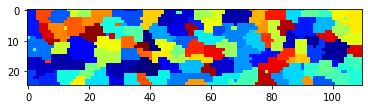

In [8]:
cluster_labels_3d = np.reshape(cluster_labels,(dims['x'],dims['y'],dims['z']))
plt.imshow(cluster_labels_3d[:,:,3].T,cmap='jet')

In [17]:
### GET CLUSTER AVERAGE SIGNAL ###

cluster_activity = {}
filters = {}
for ch in ['green','red']:
    neural_activity = brain[ch].reshape(-1, dims['t'])
    signals = []
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    cluster_activity[ch] = np.nan_to_num(np.asarray(signals)).astype('float64')
    print(cluster_activity[ch].shape)
    
    ### GET FILTERS
    sym_filter = []
    for cluster_num in range(n_clusters):
        cc_R = scipy.signal.correlate(cluster_activity[ch][cluster_num,:], fictrac['R'])
        cc_L = scipy.signal.correlate(cluster_activity[ch][cluster_num,:], fictrac['L'])
        sym_filter.append(cc_R-cc_L)
    filters[ch] = np.asarray(sym_filter)

(200, 17588)
(200, 17588)


In [18]:
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

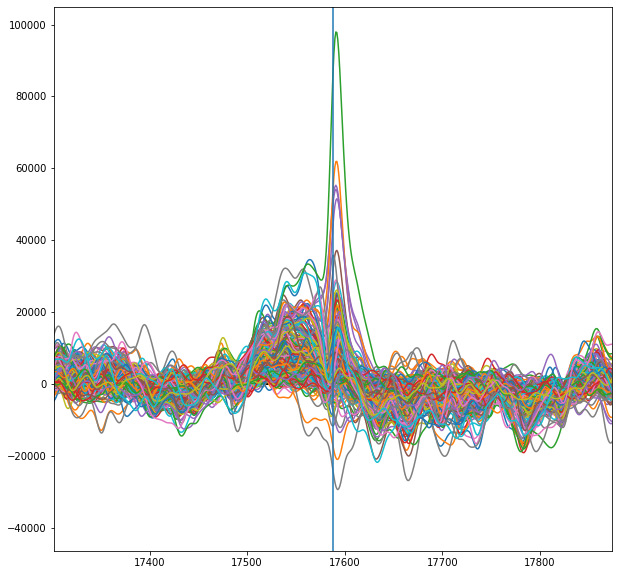

In [19]:
ch = 'green'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    #if np.abs(sym_filter[cluster_num,dims['t']]) > 30000:
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    if np.abs(np.mean(smo[dims['t']-100:dims['t']-30])) > 0:
        plt.plot(smo)#+40000*cnt)
        clusters.append(cluster_num)
        #plt.axhline(40000*cnt,color='k')
        cnt+=1

#plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

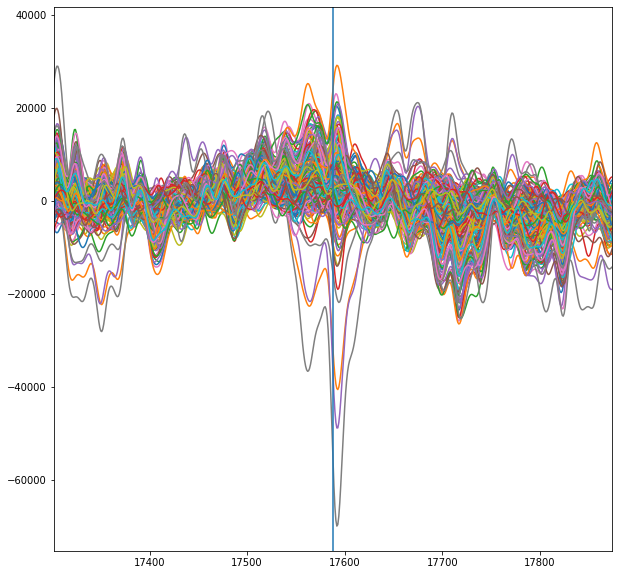

In [13]:
ch = 'red'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    #if np.abs(sym_filter[cluster_num,dims['t']]) > 30000:
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    if np.abs(np.mean(smo[dims['t']-100:dims['t']-30])) > 0:
        plt.plot(smo)#+40000*cnt)
        clusters.append(cluster_num)
        #plt.axhline(40000*cnt,color='k')
        cnt+=1

#plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

# remove poorly aligned volumes

In [9]:
file = os.path.join(load_directory,'moco','functional_channel_1_moco.h5')
with h5py.File(file, 'r') as hf:
    post_moco = hf['data'][:]

In [10]:
mean_image = ants.image_read(os.path.join(load_directory,'moco','functional_channel_1_moc_mean.nii'))
mean_image_flat = mean_image[:].flatten()

In [11]:
post_moco_flat = np.reshape(post_moco[:,:,:,:],(-1,17588))

In [12]:
moco_corr = []
for i in range(post_moco_flat.shape[1]):
    moco_corr.append(scipy.stats.pearsonr(mean_image_flat, post_moco_flat[:,i])[0])

Text(0.5, 1.0, 'corr to mean, with moco')

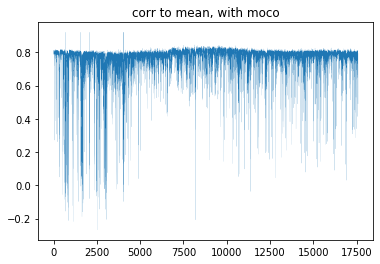

In [13]:
plt.plot(moco_corr,lw=.1)
plt.title('corr to mean, with moco')

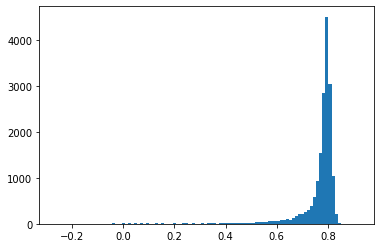

In [14]:
plt.hist(moco_corr,bins=100);

In [15]:
bad_moco = np.where(np.asarray(moco_corr)<.7)[0]
len(bad_moco)

1781

In [16]:
low_cutoff = -7000
high_cutoff = 20000

plt.hist(filters['red'][:,17588],bins=100);
plt.axvline(low_cutoff,color='k')
plt.axvline(high_cutoff,color='k')

NameError: name 'filters' is not defined

In [ ]:
bad_red_clusters = np.concatenate((np.where(filters['red'][:,17588]<low_cutoff)[0],
               np.where(filters['red'][:,17588]>high_cutoff)[0]))

In [21]:
# Smooth raw fictrac data
behavior = 'dRotLabZ'
fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
fps=100
fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec

In [35]:
turn_thresh = 200

peaks = {'L':[],'R':[]}
heights = {'L':[],'R':[]}
for turn,scalar in zip(['L', 'R'],[1,-1]):

    found_peaks = scipy.signal.find_peaks(fictrac_smoothed*scalar, height=turn_thresh,distance=20)
    pks = found_peaks[0]
    pk_height = found_peaks[1]['peak_heights']

    ### remove peaks that are too close to beginning or end
    # will do 20sec window
    # here 20sec is 1000 tps
    ind = np.where(pks>88000*2)[0]
    pks = np.delete(pks,ind)
    pk_height = np.delete(pk_height,ind)

    ind = np.where(pks<4000)[0]
    pks = np.delete(pks,ind)
    pk_height = np.delete(pk_height,ind)

    peaks[turn] = pks
    heights[turn] = pk_height

In [34]:
88000*2*10/1000

1760.0

In [56]:
1800*1000

1800000

In [61]:
peaks['L'][-1] #in units of 10ms

175814

In [57]:
peaks['L'][-1]*10 #in units of 10ms

1758140

In [23]:
len(peaks['L']), len(peaks['R'])

(532, 823)

(75000, 76000)

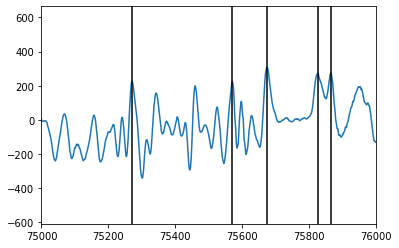

In [24]:
plt.plot(fictrac_smoothed)
for peak in peaks['L']:
    plt.axvline(peak,color='k')
plt.xlim(75000,76000)

In [25]:
fictrac_timestamps = np.arange(0,30*60*1000,10)
len(fictrac_timestamps)

180000

In [26]:
ch = 'green'
neural_activity = brain[ch].reshape(-1, dims['t'])

In [47]:
neural_activity.shape

(13750, 17588)

In [ ]:

    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_activity[ch] = np.nan_to_num(np.asarray(signals)).astype('float64')
print(cluster_activity[ch].shape)

In [48]:
cluster_activity['green'].shape

(200, 17588)

In [66]:
peak = fictrac_timestamps[peaks['L']][-1]
neural_timestamps_cluster = timestamps[:,7]
middle = np.searchsorted(neural_timestamps_cluster,peak)
middle

16778

In [69]:
neural_timestamps_cluster[-1]

1842918.2296

In [67]:
cluster_activity['green'].shape

(200, 17588)

In [42]:
cluster_num = 0
cluster_activity['green'][cluster_num,middle-300:middle+300].shape

(600,)

In [60]:
len(fictrac_timestamps)

180000

In [62]:
fictrac_timestamps[peaks['L']][-1]

1758140

In [64]:
neural_timestamps_cluster[-1]

1842918.2296

In [101]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################
### change window to 60 instead of 40 for seeing full 30sec

traces_L = {}
traces_R = {}

for ch in ['green','red']:
    neural_traces_L = []
    neural_traces_R = []

    neural_timestamps_cluster = timestamps[:,7]

    for cluster_num in range(n_clusters):

        temp_L = []
        temp_R = []
        for beh in ['L', 'R']:

            peaks_in_ms = fictrac_timestamps[peaks[beh]]

            for peak in peaks_in_ms:

                #this will give the index of the first neural data after the peak
                # 40 index will be the bin from 0 to 532ms after the peak
                middle = np.searchsorted(neural_timestamps_cluster,peak)
                if beh == 'L':
                    temp_L.append(cluster_activity[ch][cluster_num,middle-300:middle+300])
                elif beh == 'R':
                    temp_R.append(cluster_activity[ch][cluster_num,middle-300:middle+300])
                #print(len(temp_L))
        temp_L = np.asarray(temp_L)
        temp_R = np.asarray(temp_R)

        neural_traces_L.append(np.mean(temp_L,axis=0))
        neural_traces_R.append(np.mean(temp_R,axis=0))

    neural_traces_L = np.asarray(neural_traces_L)
    neural_traces_R = np.asarray(neural_traces_R)
    
    traces_L[ch] = neural_traces_L
    traces_R[ch] = neural_traces_R

In [76]:
neural_traces_L.shape

(200, 600)

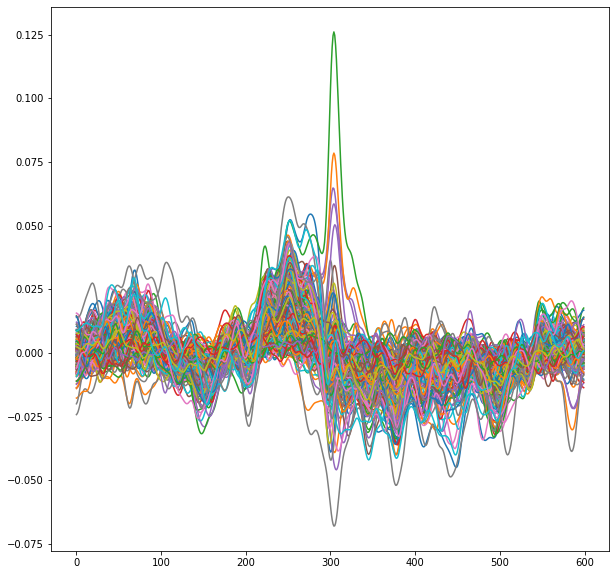

In [116]:
plt.figure(figsize=(10,10))
for i in range(200):
    trace = traces_R['green'][i,:] - traces_L['green'][i,:]
    smo = gaussian_filter1d(trace,4)
    plt.plot(smo)

In [90]:
empty = np.zeros(cluster_labels.shape)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    
    trace = neural_traces_R[cluster_num,:] - neural_traces_L[cluster_num,:]
    smo = gaussian_filter1d(trace,4)
    
    empty[cluster_indicies] = smo[300]
empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

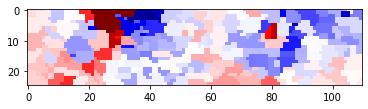

In [97]:
plt.imshow(empty[:,:,2].T,cmap='seismic',vmin=-.05,vmax=.05)

In [89]:
smo.shape

(600,)

In [51]:
# ##################################################
# ### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
# ##################################################
# ### change window to 60 instead of 40 for seeing full 30sec

# neural_traces_L = {}
# neural_traces_R = {}

# neural_timestamps_cluster = timestamps[:,7]

# for v in tqdm.tqdm(range(neural_activity.shape[0])):
    
#     neural_traces_L[v] = []
#     neural_traces_R[v] = []

#     for beh in ['L', 'R']:

#         peaks_in_ms = fictrac_timestamps[peaks[beh]]

#         for peak in peaks_in_ms:

#             #this will give the index of the first neural data after the peak
#             # 40 index will be the bin from 0 to 532ms after the peak
#             middle = np.searchsorted(neural_timestamps_cluster,peak)
#             if beh == 'L':
#                 neural_traces_L[v].append(neural_activity[v,middle-300:middle+300])
#             elif beh == 'R':
#                 neural_traces_R[v].append(neural_activity[v,middle-300:middle+300])

#     neural_traces_L[v] = np.asarray(neural_traces_L[v])
#     neural_traces_R[v] = np.asarray(neural_traces_R[v])

100%|██████████| 13750/13750 [01:16<00:00, 180.70it/s]


In [49]:
cluster_activity['green'].shape

(200, 17588)

In [51]:
cluster_activity['green'][:,-1]

array([-0.11171767,  0.08730712,  0.3096329 , -0.27785012,  0.04842036,
       -0.11775602, -0.0132625 ,  0.02981616,  0.2669777 ,  0.19234809,
        0.08217563, -0.16219111, -0.0228561 ,  0.02061002,  0.10561544,
       -0.07212321,  0.0045515 , -0.3292408 ,  0.20790911, -0.27670473,
        0.25321949, -0.05157711,  0.15052018,  0.23593608, -0.06413198,
        0.22263257,  0.13084973,  0.02070513,  0.14691511, -0.20246521,
       -0.0434371 , -0.08437461, -0.14113158,  0.04031729, -0.07919893,
        0.36919373,  0.17834899, -0.25315386,  0.2950432 ,  0.0197199 ,
        0.07825876, -0.05904117,  0.3768039 ,  0.0290951 ,  0.22647156,
       -0.07459453,  0.15969867,  0.55004013,  0.06485512, -0.24389526,
        0.03219775,  0.16105722,  0.14979295, -0.20704116,  0.63414162,
        0.2178652 ,  0.14781235,  0.04087194,  0.14831872,  0.20113285,
        0.15413253,  0.07681338, -0.02634368,  0.10019019,  0.1642586 ,
        0.604976  , -0.026332  , -0.15305969,  0.14940141,  0.18

In [56]:
neural_traces_L[10][0].shape

(0,)

In [ ]:
neural_activity

In [152]:
np.argmin(filters['red'][:,17588])

157

In [245]:
empty = np.zeros(cluster_labels.shape)
for cluster_num in [137]:#range(n_clusters):
    cluster_indicies = np.where(cluster_labels==cluster_num)[0]
    empty[cluster_indicies] = 1
empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

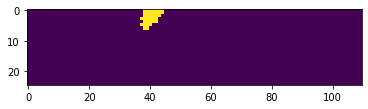

In [249]:
plt.imshow(empty[:,:,3].T)

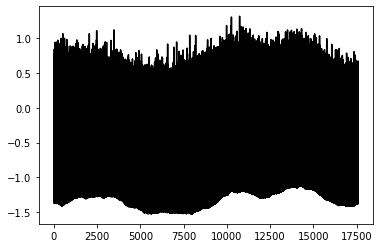

In [120]:
cluster_num = 141

plt.plot(cluster_activity['red'][cluster_num,:],'k')
activity = np.copy(cluster_activity['red'][cluster_num,:])
activity[bad_moco] = 0

plt.plot(activity,'r')

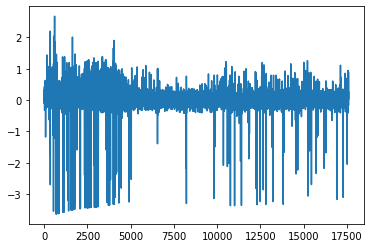

In [54]:
activity = np.copy(cluster_activity[ch][cluster_num,:])
activity[bad_moco] = 0
plt.plot(activity)

In [53]:
activity = cluster_activity[ch][cluster_num,:]
activity[14086]

-0.012866327539086342

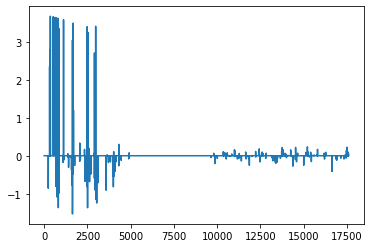

In [55]:
plt.plot(activity-cluster_activity[ch][cluster_num,:])

In [115]:
filters['red'].shape

(400, 35175)

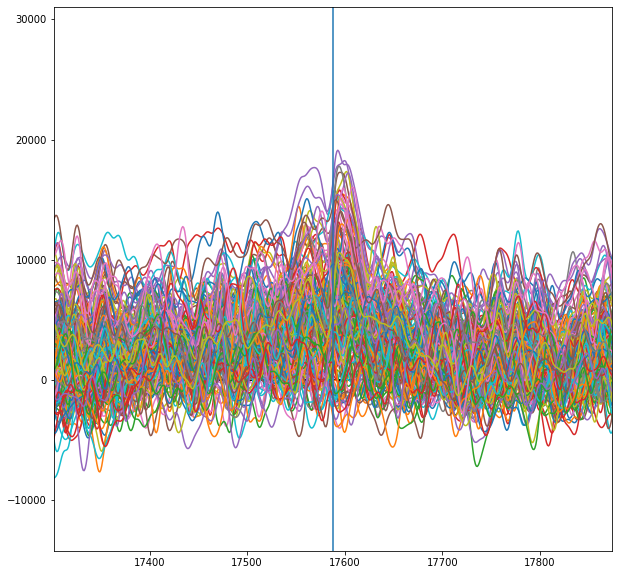

In [203]:
ch = 'red'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    if cluster_num in bad_red_clusters:
        continue
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    plt.plot(smo)
    clusters.append(cluster_num)
    cnt+=1

#plt.plot(sym_filter[hemi][117,:],color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [184]:
filters[ch][:,:].shape

(200, 35175)

In [ ]:
plt.hist(filters[ch][cluster_num,:])

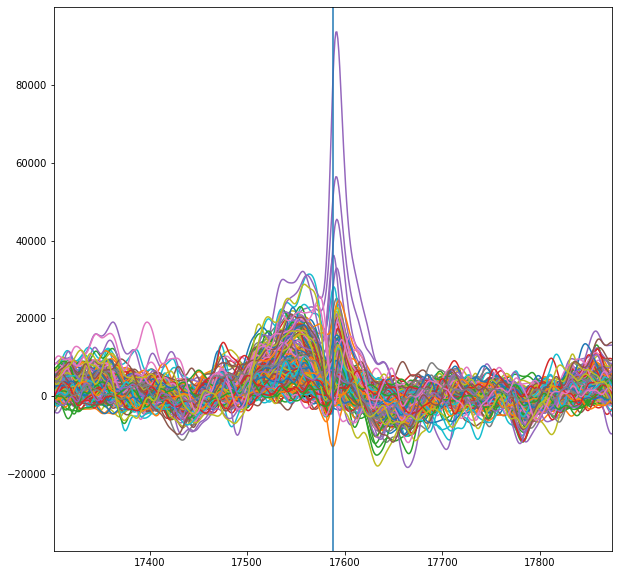

In [238]:
ch = 'green'

plt.figure(figsize=(10,10))
plt.axhline(0,color='k',lw=2)
clusters = []
cnt = 0
for cluster_num in range(n_clusters):
    if cluster_num in bad_red_clusters:
        continue
    smo = gaussian_filter1d(filters[ch][cluster_num,:],4)
    plt.plot(smo)
    clusters.append(cluster_num)
    cnt+=1

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

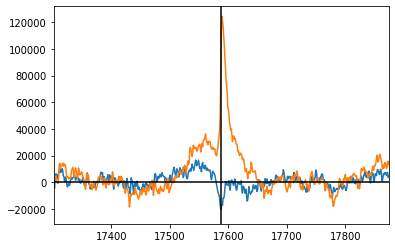

In [252]:
plt.plot(filters['green'][137,:])
plt.plot(filters['green'][162,:])
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')

In [244]:
bad_red_clusters

array([ 41,  94, 124, 157, 167, 106, 120, 134, 151, 168, 187])

In [243]:
np.argsort(filters['green'][:,17588])

array([157, 137, 197,  41, 167, 126,  60, 168, 186,  15,  79,  45, 181,
        81,  44,  73,  62, 124,  66,  61, 172, 136,  28, 196, 156,  56,
       194, 150,  80, 129, 104,  31, 149, 141,  82,  18, 169,  11,   6,
        71,   3,  46, 177, 132,  33,  97, 160, 193, 110,  89, 135,  59,
        38,  92,  21,  12,  93, 148, 111,  70,   1,  83, 116, 142, 131,
        57,  76,   2, 182,  49, 112,  19, 147, 171,  55,  13,  42, 173,
        95, 198,  94,  90, 138,  10,  53,  86, 176, 192, 139, 107,  67,
        36,  32,  74,  27,  77, 185,  88, 191, 109,  40,  34, 179,  22,
         4, 130,  47,  48, 180, 105,  37,  65, 189, 183,  14,   5,  87,
        58,  29,  35, 121,  84,   0,  26, 118, 199, 175,  51,   7, 143,
       163,   9, 154, 103, 159, 195, 102, 165,  72, 127,  43,  16,  39,
       155, 125, 144,  64,  30,  85,  98,  63,  25, 166, 100, 190, 123,
       146,  91,  96, 161,  17, 164,  54,  20, 158,  50, 119, 152, 170,
       145, 108,  69, 113,   8,  78,  68, 114, 188, 153, 115, 12

In [106]:
cluster_num = 0
ch = 'green'
trace = traces_R[ch][cluster_num,:] - traces_L[ch][cluster_num,:]
trace.shape

(600,)

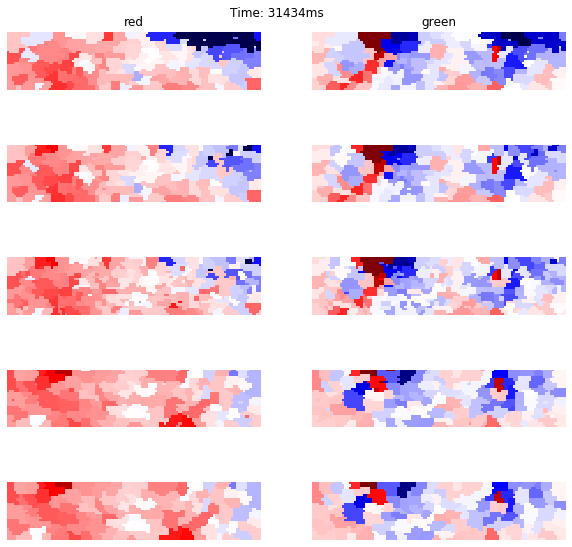

In [110]:
plt.figure(figsize=(10,10))


t=300

for ch in ['red','green']:
    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        
        trace = traces_R[ch][cluster_num,:] - traces_L[ch][cluster_num,:]
        smo = gaussian_filter1d(trace,4)
        
        empty[cluster_indicies] = smo[t]
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    for z in range(dims['z']):
        if ch == 'red':
            plt.subplot(dims['z'],2,z*2+1)
            if z == 0:
                plt.title('red')
        else:
            plt.subplot(dims['z'],2,z*2+2)
            if z == 0:
                plt.title('green')
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=0.05,vmin=-0.05)
        plt.axis('off')
        
        
        
    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)

In [111]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20240213_movie_339'
os.mkdir(save_path)

In [115]:
plt.figure(figsize=(10,10))

for k,t in tqdm.tqdm(enumerate(np.arange(0,302,2))):

    for ch in ['red','green']:
        empty = np.zeros(cluster_labels.shape)
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels==cluster_num)[0]
            
            trace = traces_R[ch][cluster_num,:] - traces_L[ch][cluster_num,:]
            smo = gaussian_filter1d(trace,4)

            empty[cluster_indicies] = smo[t]
            
        empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

        for z in range(dims['z']):
            if ch == 'red':
                plt.subplot(dims['z'],2,z*2+1)
                if z == 0:
                    plt.title('red')
            else:
                plt.subplot(dims['z'],2,z*2+2)
                if z == 0:
                    plt.title('green')
            plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=0.05,vmin=-0.05)
            plt.axis('off')

    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()

151it [01:19,  1.91it/s]


<Figure size 720x720 with 0 Axes>

In [114]:
np.arange(0,302,2)

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296, 298, 300])

In [154]:
for k,t in tqdm.tqdm(enumerate(np.arange(-140,2,2))):

    empty = np.zeros(cluster_labels.shape)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_labels==cluster_num)[0]
        empty[cluster_indicies] = sym_filter[cluster_num,dims['t']+t]
    empty = np.reshape(empty,(dims['x'],dims['y'],dims['z']))

    plt.figure(figsize=(10,20))
    for z in range(dims['z']):
        plt.subplot(dims['z'],1,z+1)
        plt.imshow(empty[:,:,z].T,cmap='seismic',vmax=10000,vmin=-10000)
        plt.axis('off')
    plt.suptitle(F"Time: {int(t*timestep)}ms",y=.89)
    
    fname = os.path.join(save_path, '{0:05d}.png'.format(k))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
    plt.clf()

20it [00:12,  1.54it/s]/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
71it [00:45,  1.57it/s]


<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

<Figure size 720x1440 with 0 Axes>

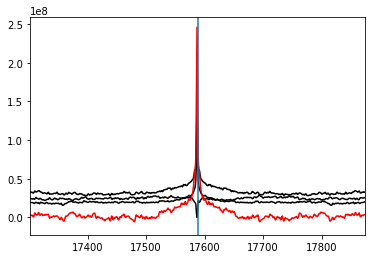

In [256]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['T'], fictrac['T'])
plt.plot(cc,color='r')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])